In this notebook, we train a classifier model for predicting whether a PA claim will be approved or not, using CatBoost.
We map the cateorical features to integers, perform GridSearchCV for hyperparameter tuning, and look at the feature importances for the best model.


In [1]:
# Import the necessary packages.

from sklearn.datasets import load_iris

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from seaborn import set_style
set_style("whitegrid")

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import GridSearchCV

C:\Users\ozkan\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Load the data.
date = pd.read_csv("../Data/dim_date.csv")
claims = pd.read_csv("../Data/dim_claims.csv")
pa = pd.read_csv("../Data/dim_pa.csv")
bridge = pd.read_csv("../Data/bridge.csv")

In [3]:
# Join claims with bridge, in df dataframe.
df = claims.copy()
df = df.set_index('dim_claim_id').join(bridge.set_index('dim_claim_id'))
df.head()

# Join the pa with rejected claims, in pa_df dataframe.
pa_df = df.copy().dropna()
pa_df = pa_df.set_index('dim_pa_id').join(pa.set_index('dim_pa_id'))
pa_df.head()

,bin,drug,reject_code,pharmacy_claim_approved,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved
dim_pa_id,,,,,,,,,
1.0,417380,A,75.0,0,1,1,1,0,1
2.0,417740,A,76.0,0,1,1,0,0,1
3.0,417380,A,75.0,0,1,0,0,1,1
4.0,999001,A,76.0,0,1,1,1,0,1
5.0,417614,A,70.0,0,1,0,1,0,1


In [4]:
## Map bins
## 417380 -> 0
## 417614 -> 1
## 417740 -> 2
## 999001 -> 3

pa_df['bin_no'] = 3
pa_df.loc[pa_df.bin == 417380,'bin_no'] = 0
pa_df.loc[pa_df.bin == 417614,'bin_no'] = 1
pa_df.loc[pa_df.bin == 417740,'bin_no'] = 2

## Map drugs
## A -> 0
## B -> 1
## C -> 2

pa_df['drug_no'] = 0
pa_df.loc[pa_df.drug == 'B','drug_no'] = 1
pa_df.loc[pa_df.drug == 'C','drug_no'] = 2


## Map reject codes
## 70.0 -> 0
## 75.0 -> 1
## 76.0 -> 2

pa_df['reject_no'] = 0
pa_df.loc[pa_df.reject_code == 75.0,'reject_no'] = 1
pa_df.loc[pa_df.reject_code == 76.0,'reject_no'] = 2

In [5]:
#For stratification, concatenate the features that will be used in the model

concat_features = ['bin_no','drug_no', 'reject_no', 'correct_diagnosis', 'tried_and_failed', 'contraindication']

pa_df['feature_id'] = ''

for feature in concat_features:
    pa_df['feature_id'] = pa_df['feature_id'] + pa_df[feature].astype(str)
    
pa_df['concat_all'] = pa_df['feature_id'] + pa_df['pa_approved'].astype(str)

In [6]:
# Perform train-test split.
pa_train, pa_test = train_test_split( pa_df.copy(),
                                      test_size = .2,
                                      random_state = 123,
                                      shuffle = True,
                                      stratify = pa_df['concat_all'])

In [7]:
# Further perform train-validation split.
pa_tt, pa_val = train_test_split( pa_train.copy(),
                                      test_size = .2,
                                      random_state = 235,
                                      shuffle = True,
                                      stratify = pa_train['concat_all'])

In [30]:
# Perform GridSearchCV for hyperparameter tuning. (f1_score is used.)

features = concat_features

grid_cv = GridSearchCV(CatBoostClassifier(),
                          param_grid = {'iterations':range(5,50),
                                           'learning_rate':[1],
                                        'depth': range(1,17)},
                          scoring = 'f1',
                          cv = 5)

grid_cv.fit(pa_tt[features].values, pa_tt['pa_approved'])


0:	learn: 0.4203477	total: 32.8ms	remaining: 131ms
1:	learn: 0.3845642	total: 56.3ms	remaining: 84.4ms
2:	learn: 0.3766479	total: 80.6ms	remaining: 53.7ms
3:	learn: 0.3751209	total: 106ms	remaining: 26.5ms
4:	learn: 0.3728728	total: 133ms	remaining: 0us
0:	learn: 0.4206893	total: 36.8ms	remaining: 147ms
1:	learn: 0.3850249	total: 71.1ms	remaining: 107ms
2:	learn: 0.3771835	total: 108ms	remaining: 72.3ms
3:	learn: 0.3756758	total: 152ms	remaining: 37.9ms
4:	learn: 0.3734691	total: 196ms	remaining: 0us
0:	learn: 0.4201733	total: 29.5ms	remaining: 118ms
1:	learn: 0.3844435	total: 54.3ms	remaining: 81.4ms
2:	learn: 0.3763914	total: 79.3ms	remaining: 52.9ms
3:	learn: 0.3749688	total: 107ms	remaining: 26.7ms
4:	learn: 0.3727752	total: 134ms	remaining: 0us
0:	learn: 0.4206929	total: 39.4ms	remaining: 158ms
1:	learn: 0.3849253	total: 72.2ms	remaining: 108ms
2:	learn: 0.3771027	total: 105ms	remaining: 70.1ms
3:	learn: 0.3756155	total: 137ms	remaining: 34.4ms
4:	learn: 0.3734097	total: 175ms	rem

0:	learn: 0.4205789	total: 34.8ms	remaining: 279ms
1:	learn: 0.3849151	total: 67.4ms	remaining: 236ms
2:	learn: 0.3769658	total: 124ms	remaining: 247ms
3:	learn: 0.3754985	total: 162ms	remaining: 203ms
4:	learn: 0.3732954	total: 210ms	remaining: 168ms
5:	learn: 0.3721491	total: 255ms	remaining: 127ms
6:	learn: 0.3714965	total: 302ms	remaining: 86.4ms
7:	learn: 0.3714451	total: 350ms	remaining: 43.8ms
8:	learn: 0.3714054	total: 398ms	remaining: 0us
0:	learn: 0.4203477	total: 44.7ms	remaining: 402ms
1:	learn: 0.3845642	total: 81.5ms	remaining: 326ms
2:	learn: 0.3766479	total: 123ms	remaining: 287ms
3:	learn: 0.3751209	total: 159ms	remaining: 238ms
4:	learn: 0.3728728	total: 196ms	remaining: 196ms
5:	learn: 0.3716965	total: 235ms	remaining: 156ms
6:	learn: 0.3709637	total: 279ms	remaining: 120ms
7:	learn: 0.3709078	total: 319ms	remaining: 79.7ms
8:	learn: 0.3708665	total: 350ms	remaining: 38.9ms
9:	learn: 0.3708821	total: 385ms	remaining: 0us
0:	learn: 0.4206893	total: 41.1ms	remaining: 3

6:	learn: 0.3714965	total: 246ms	remaining: 175ms
7:	learn: 0.3714451	total: 283ms	remaining: 141ms
8:	learn: 0.3714054	total: 318ms	remaining: 106ms
9:	learn: 0.3714045	total: 350ms	remaining: 70.1ms
10:	learn: 0.3714063	total: 380ms	remaining: 34.5ms
11:	learn: 0.3713457	total: 416ms	remaining: 0us
0:	learn: 0.4203477	total: 38ms	remaining: 457ms
1:	learn: 0.3845642	total: 71.9ms	remaining: 395ms
2:	learn: 0.3766479	total: 107ms	remaining: 356ms
3:	learn: 0.3751209	total: 141ms	remaining: 318ms
4:	learn: 0.3728728	total: 177ms	remaining: 283ms
5:	learn: 0.3716965	total: 214ms	remaining: 249ms
6:	learn: 0.3709637	total: 261ms	remaining: 224ms
7:	learn: 0.3709078	total: 296ms	remaining: 185ms
8:	learn: 0.3708665	total: 331ms	remaining: 147ms
9:	learn: 0.3708821	total: 363ms	remaining: 109ms
10:	learn: 0.3708755	total: 390ms	remaining: 71ms
11:	learn: 0.3708004	total: 428ms	remaining: 35.6ms
12:	learn: 0.3707868	total: 464ms	remaining: 0us
0:	learn: 0.4206893	total: 41.8ms	remaining: 50

12:	learn: 0.3714718	total: 499ms	remaining: 76.8ms
13:	learn: 0.3714565	total: 533ms	remaining: 38.1ms
14:	learn: 0.3714584	total: 570ms	remaining: 0us
0:	learn: 0.4201733	total: 43.4ms	remaining: 607ms
1:	learn: 0.3844435	total: 84.4ms	remaining: 548ms
2:	learn: 0.3763914	total: 124ms	remaining: 495ms
3:	learn: 0.3749688	total: 163ms	remaining: 449ms
4:	learn: 0.3727752	total: 204ms	remaining: 408ms
5:	learn: 0.3716161	total: 244ms	remaining: 366ms
6:	learn: 0.3709683	total: 289ms	remaining: 330ms
7:	learn: 0.3709261	total: 333ms	remaining: 291ms
8:	learn: 0.3708880	total: 368ms	remaining: 245ms
9:	learn: 0.3708959	total: 402ms	remaining: 201ms
10:	learn: 0.3707960	total: 445ms	remaining: 162ms
11:	learn: 0.3707411	total: 486ms	remaining: 121ms
12:	learn: 0.3707460	total: 520ms	remaining: 80ms
13:	learn: 0.3707307	total: 557ms	remaining: 39.8ms
14:	learn: 0.3707194	total: 597ms	remaining: 0us
0:	learn: 0.4206929	total: 38.3ms	remaining: 536ms
1:	learn: 0.3849253	total: 73.4ms	remaini

7:	learn: 0.3709261	total: 271ms	remaining: 305ms
8:	learn: 0.3708880	total: 307ms	remaining: 273ms
9:	learn: 0.3708959	total: 339ms	remaining: 237ms
10:	learn: 0.3707960	total: 364ms	remaining: 199ms
11:	learn: 0.3707411	total: 389ms	remaining: 162ms
12:	learn: 0.3707460	total: 411ms	remaining: 126ms
13:	learn: 0.3707307	total: 435ms	remaining: 93.2ms
14:	learn: 0.3707194	total: 464ms	remaining: 61.8ms
15:	learn: 0.3707106	total: 488ms	remaining: 30.5ms
16:	learn: 0.3707019	total: 524ms	remaining: 0us
0:	learn: 0.4206929	total: 31.5ms	remaining: 504ms
1:	learn: 0.3849253	total: 58.3ms	remaining: 438ms
2:	learn: 0.3771027	total: 85.7ms	remaining: 400ms
3:	learn: 0.3756155	total: 114ms	remaining: 372ms
4:	learn: 0.3734097	total: 143ms	remaining: 342ms
5:	learn: 0.3723952	total: 180ms	remaining: 329ms
6:	learn: 0.3721170	total: 212ms	remaining: 302ms
7:	learn: 0.3720727	total: 240ms	remaining: 271ms
8:	learn: 0.3718095	total: 283ms	remaining: 252ms
9:	learn: 0.3716166	total: 325ms	remain

14:	learn: 0.3714584	total: 513ms	remaining: 137ms
15:	learn: 0.3714220	total: 553ms	remaining: 104ms
16:	learn: 0.3713896	total: 589ms	remaining: 69.2ms
17:	learn: 0.3713874	total: 623ms	remaining: 34.6ms
18:	learn: 0.3713708	total: 657ms	remaining: 0us
0:	learn: 0.4201733	total: 41ms	remaining: 738ms
1:	learn: 0.3844435	total: 72.2ms	remaining: 614ms
2:	learn: 0.3763914	total: 103ms	remaining: 551ms
3:	learn: 0.3749688	total: 134ms	remaining: 501ms
4:	learn: 0.3727752	total: 168ms	remaining: 470ms
5:	learn: 0.3716161	total: 202ms	remaining: 438ms
6:	learn: 0.3709683	total: 237ms	remaining: 406ms
7:	learn: 0.3709261	total: 267ms	remaining: 367ms
8:	learn: 0.3708880	total: 304ms	remaining: 338ms
9:	learn: 0.3708959	total: 330ms	remaining: 297ms
10:	learn: 0.3707960	total: 357ms	remaining: 260ms
11:	learn: 0.3707411	total: 385ms	remaining: 225ms
12:	learn: 0.3707460	total: 408ms	remaining: 188ms
13:	learn: 0.3707307	total: 434ms	remaining: 155ms
14:	learn: 0.3707194	total: 478ms	remaini

0:	learn: 0.4203477	total: 40.4ms	remaining: 808ms
1:	learn: 0.3845642	total: 77.5ms	remaining: 736ms
2:	learn: 0.3766479	total: 112ms	remaining: 675ms
3:	learn: 0.3751209	total: 147ms	remaining: 623ms
4:	learn: 0.3728728	total: 189ms	remaining: 604ms
5:	learn: 0.3716965	total: 226ms	remaining: 564ms
6:	learn: 0.3709637	total: 266ms	remaining: 531ms
7:	learn: 0.3709078	total: 300ms	remaining: 487ms
8:	learn: 0.3708665	total: 325ms	remaining: 433ms
9:	learn: 0.3708821	total: 349ms	remaining: 384ms
10:	learn: 0.3708755	total: 370ms	remaining: 337ms
11:	learn: 0.3708004	total: 398ms	remaining: 299ms
12:	learn: 0.3707868	total: 424ms	remaining: 261ms
13:	learn: 0.3707595	total: 449ms	remaining: 225ms
14:	learn: 0.3707213	total: 490ms	remaining: 196ms
15:	learn: 0.3707107	total: 528ms	remaining: 165ms
16:	learn: 0.3706941	total: 559ms	remaining: 131ms
17:	learn: 0.3706536	total: 595ms	remaining: 99.1ms
18:	learn: 0.3706404	total: 633ms	remaining: 66.6ms
19:	learn: 0.3706345	total: 667ms	rem

16:	learn: 0.3707019	total: 705ms	remaining: 207ms
17:	learn: 0.3706996	total: 753ms	remaining: 167ms
18:	learn: 0.3706988	total: 786ms	remaining: 124ms
19:	learn: 0.3706790	total: 826ms	remaining: 82.6ms
20:	learn: 0.3706776	total: 863ms	remaining: 41.1ms
21:	learn: 0.3706580	total: 900ms	remaining: 0us
0:	learn: 0.4206929	total: 46.2ms	remaining: 970ms
1:	learn: 0.3849253	total: 96.9ms	remaining: 969ms
2:	learn: 0.3771027	total: 150ms	remaining: 950ms
3:	learn: 0.3756155	total: 195ms	remaining: 879ms
4:	learn: 0.3734097	total: 241ms	remaining: 819ms
5:	learn: 0.3723952	total: 289ms	remaining: 770ms
6:	learn: 0.3721170	total: 339ms	remaining: 727ms
7:	learn: 0.3720727	total: 373ms	remaining: 652ms
8:	learn: 0.3718095	total: 420ms	remaining: 607ms
9:	learn: 0.3716166	total: 465ms	remaining: 557ms
10:	learn: 0.3716049	total: 515ms	remaining: 515ms
11:	learn: 0.3715983	total: 549ms	remaining: 457ms
12:	learn: 0.3715813	total: 593ms	remaining: 411ms
13:	learn: 0.3715019	total: 641ms	remai

0:	learn: 0.4203477	total: 34.8ms	remaining: 801ms
1:	learn: 0.3845642	total: 70.1ms	remaining: 771ms
2:	learn: 0.3766479	total: 108ms	remaining: 753ms
3:	learn: 0.3751209	total: 144ms	remaining: 722ms
4:	learn: 0.3728728	total: 181ms	remaining: 689ms
5:	learn: 0.3716965	total: 215ms	remaining: 646ms
6:	learn: 0.3709637	total: 255ms	remaining: 620ms
7:	learn: 0.3709078	total: 289ms	remaining: 578ms
8:	learn: 0.3708665	total: 322ms	remaining: 537ms
9:	learn: 0.3708821	total: 351ms	remaining: 492ms
10:	learn: 0.3708755	total: 376ms	remaining: 444ms
11:	learn: 0.3708004	total: 412ms	remaining: 412ms
12:	learn: 0.3707868	total: 449ms	remaining: 380ms
13:	learn: 0.3707595	total: 482ms	remaining: 345ms
14:	learn: 0.3707213	total: 512ms	remaining: 307ms
15:	learn: 0.3707107	total: 552ms	remaining: 276ms
16:	learn: 0.3706941	total: 587ms	remaining: 242ms
17:	learn: 0.3706536	total: 622ms	remaining: 207ms
18:	learn: 0.3706404	total: 660ms	remaining: 174ms
19:	learn: 0.3706345	total: 694ms	remai

20:	learn: 0.3713499	total: 706ms	remaining: 134ms
21:	learn: 0.3713422	total: 735ms	remaining: 100ms
22:	learn: 0.3713421	total: 763ms	remaining: 66.3ms
23:	learn: 0.3713405	total: 792ms	remaining: 33ms
24:	learn: 0.3713420	total: 817ms	remaining: 0us
0:	learn: 0.4201733	total: 34.4ms	remaining: 826ms
1:	learn: 0.3844435	total: 72.3ms	remaining: 831ms
2:	learn: 0.3763914	total: 105ms	remaining: 769ms
3:	learn: 0.3749688	total: 138ms	remaining: 727ms
4:	learn: 0.3727752	total: 175ms	remaining: 701ms
5:	learn: 0.3716161	total: 206ms	remaining: 651ms
6:	learn: 0.3709683	total: 243ms	remaining: 625ms
7:	learn: 0.3709261	total: 278ms	remaining: 590ms
8:	learn: 0.3708880	total: 312ms	remaining: 554ms
9:	learn: 0.3708959	total: 343ms	remaining: 514ms
10:	learn: 0.3707960	total: 380ms	remaining: 483ms
11:	learn: 0.3707411	total: 410ms	remaining: 445ms
12:	learn: 0.3707460	total: 436ms	remaining: 403ms
13:	learn: 0.3707307	total: 470ms	remaining: 369ms
14:	learn: 0.3707194	total: 506ms	remaini

7:	learn: 0.3720727	total: 278ms	remaining: 627ms
8:	learn: 0.3718095	total: 318ms	remaining: 601ms
9:	learn: 0.3716166	total: 357ms	remaining: 572ms
10:	learn: 0.3716049	total: 395ms	remaining: 539ms
11:	learn: 0.3715983	total: 421ms	remaining: 491ms
12:	learn: 0.3715813	total: 458ms	remaining: 458ms
13:	learn: 0.3715019	total: 495ms	remaining: 424ms
14:	learn: 0.3714814	total: 533ms	remaining: 391ms
15:	learn: 0.3714551	total: 567ms	remaining: 355ms
16:	learn: 0.3713936	total: 601ms	remaining: 318ms
17:	learn: 0.3713625	total: 639ms	remaining: 284ms
18:	learn: 0.3713488	total: 674ms	remaining: 248ms
19:	learn: 0.3713381	total: 708ms	remaining: 212ms
20:	learn: 0.3713256	total: 743ms	remaining: 177ms
21:	learn: 0.3713207	total: 772ms	remaining: 140ms
22:	learn: 0.3713094	total: 807ms	remaining: 105ms
23:	learn: 0.3713105	total: 836ms	remaining: 69.7ms
24:	learn: 0.3712994	total: 865ms	remaining: 34.6ms
25:	learn: 0.3712954	total: 896ms	remaining: 0us
0:	learn: 0.4205789	total: 34.5ms	

13:	learn: 0.3713494	total: 487ms	remaining: 453ms
14:	learn: 0.3713156	total: 520ms	remaining: 416ms
15:	learn: 0.3713026	total: 560ms	remaining: 385ms
16:	learn: 0.3712651	total: 601ms	remaining: 353ms
17:	learn: 0.3712539	total: 638ms	remaining: 319ms
18:	learn: 0.3712366	total: 674ms	remaining: 284ms
19:	learn: 0.3712390	total: 715ms	remaining: 250ms
20:	learn: 0.3712334	total: 742ms	remaining: 212ms
21:	learn: 0.3712296	total: 769ms	remaining: 175ms
22:	learn: 0.3712244	total: 796ms	remaining: 138ms
23:	learn: 0.3712213	total: 822ms	remaining: 103ms
24:	learn: 0.3712115	total: 850ms	remaining: 68ms
25:	learn: 0.3711991	total: 888ms	remaining: 34.1ms
26:	learn: 0.3711978	total: 922ms	remaining: 0us
0:	learn: 0.4203477	total: 32.3ms	remaining: 872ms
1:	learn: 0.3845642	total: 63.5ms	remaining: 825ms
2:	learn: 0.3766479	total: 95.1ms	remaining: 792ms
3:	learn: 0.3751209	total: 125ms	remaining: 751ms
4:	learn: 0.3728728	total: 161ms	remaining: 739ms
5:	learn: 0.3716965	total: 192ms	re

12:	learn: 0.3707868	total: 451ms	remaining: 555ms
13:	learn: 0.3707595	total: 487ms	remaining: 522ms
14:	learn: 0.3707213	total: 524ms	remaining: 489ms
15:	learn: 0.3707107	total: 573ms	remaining: 466ms
16:	learn: 0.3706941	total: 613ms	remaining: 433ms
17:	learn: 0.3706536	total: 650ms	remaining: 397ms
18:	learn: 0.3706404	total: 688ms	remaining: 362ms
19:	learn: 0.3706345	total: 727ms	remaining: 327ms
20:	learn: 0.3706360	total: 760ms	remaining: 289ms
21:	learn: 0.3706353	total: 797ms	remaining: 254ms
22:	learn: 0.3706320	total: 822ms	remaining: 215ms
23:	learn: 0.3706195	total: 851ms	remaining: 177ms
24:	learn: 0.3706246	total: 878ms	remaining: 140ms
25:	learn: 0.3706054	total: 908ms	remaining: 105ms
26:	learn: 0.3706001	total: 936ms	remaining: 69.3ms
27:	learn: 0.3705995	total: 970ms	remaining: 34.6ms
28:	learn: 0.3705919	total: 1s	remaining: 0us
0:	learn: 0.4206893	total: 36.7ms	remaining: 1.03s
1:	learn: 0.3850249	total: 73.6ms	remaining: 993ms
2:	learn: 0.3771835	total: 109ms	r

0:	learn: 0.4206893	total: 35.7ms	remaining: 1.04s
1:	learn: 0.3850249	total: 72.6ms	remaining: 1.02s
2:	learn: 0.3771835	total: 106ms	remaining: 950ms
3:	learn: 0.3756758	total: 142ms	remaining: 923ms
4:	learn: 0.3734691	total: 184ms	remaining: 918ms
5:	learn: 0.3723316	total: 216ms	remaining: 864ms
6:	learn: 0.3716515	total: 256ms	remaining: 843ms
7:	learn: 0.3716074	total: 294ms	remaining: 810ms
8:	learn: 0.3715761	total: 335ms	remaining: 781ms
9:	learn: 0.3715751	total: 369ms	remaining: 738ms
10:	learn: 0.3715605	total: 410ms	remaining: 708ms
11:	learn: 0.3714717	total: 441ms	remaining: 661ms
12:	learn: 0.3714718	total: 465ms	remaining: 608ms
13:	learn: 0.3714565	total: 499ms	remaining: 570ms
14:	learn: 0.3714584	total: 527ms	remaining: 527ms
15:	learn: 0.3714220	total: 559ms	remaining: 489ms
16:	learn: 0.3713896	total: 591ms	remaining: 452ms
17:	learn: 0.3713874	total: 623ms	remaining: 416ms
18:	learn: 0.3713708	total: 658ms	remaining: 381ms
19:	learn: 0.3713623	total: 691ms	remai

13:	learn: 0.3714565	total: 487ms	remaining: 591ms
14:	learn: 0.3714584	total: 514ms	remaining: 548ms
15:	learn: 0.3714220	total: 544ms	remaining: 510ms
16:	learn: 0.3713896	total: 583ms	remaining: 480ms
17:	learn: 0.3713874	total: 619ms	remaining: 447ms
18:	learn: 0.3713708	total: 655ms	remaining: 414ms
19:	learn: 0.3713623	total: 690ms	remaining: 379ms
20:	learn: 0.3713499	total: 730ms	remaining: 348ms
21:	learn: 0.3713422	total: 769ms	remaining: 315ms
22:	learn: 0.3713421	total: 809ms	remaining: 281ms
23:	learn: 0.3713405	total: 850ms	remaining: 248ms
24:	learn: 0.3713420	total: 886ms	remaining: 213ms
25:	learn: 0.3713297	total: 920ms	remaining: 177ms
26:	learn: 0.3713249	total: 955ms	remaining: 141ms
27:	learn: 0.3713223	total: 993ms	remaining: 106ms
28:	learn: 0.3713179	total: 1.03s	remaining: 70.8ms
29:	learn: 0.3713217	total: 1.06s	remaining: 35.4ms
30:	learn: 0.3713226	total: 1.1s	remaining: 0us
0:	learn: 0.4201733	total: 41.2ms	remaining: 1.24s
1:	learn: 0.3844435	total: 82ms	

24:	learn: 0.3713420	total: 867ms	remaining: 243ms
25:	learn: 0.3713297	total: 901ms	remaining: 208ms
26:	learn: 0.3713249	total: 934ms	remaining: 173ms
27:	learn: 0.3713223	total: 972ms	remaining: 139ms
28:	learn: 0.3713179	total: 1.01s	remaining: 104ms
29:	learn: 0.3713217	total: 1.04s	remaining: 69.5ms
30:	learn: 0.3713226	total: 1.08s	remaining: 34.8ms
31:	learn: 0.3713177	total: 1.11s	remaining: 0us
0:	learn: 0.4201733	total: 35.5ms	remaining: 1.1s
1:	learn: 0.3844435	total: 70.4ms	remaining: 1.05s
2:	learn: 0.3763914	total: 105ms	remaining: 1.01s
3:	learn: 0.3749688	total: 135ms	remaining: 943ms
4:	learn: 0.3727752	total: 176ms	remaining: 953ms
5:	learn: 0.3716161	total: 213ms	remaining: 921ms
6:	learn: 0.3709683	total: 253ms	remaining: 903ms
7:	learn: 0.3709261	total: 287ms	remaining: 861ms
8:	learn: 0.3708880	total: 322ms	remaining: 823ms
9:	learn: 0.3708959	total: 351ms	remaining: 772ms
10:	learn: 0.3707960	total: 382ms	remaining: 730ms
11:	learn: 0.3707411	total: 407ms	remain

28:	learn: 0.3713179	total: 1.08s	remaining: 149ms
29:	learn: 0.3713217	total: 1.11s	remaining: 111ms
30:	learn: 0.3713226	total: 1.15s	remaining: 74ms
31:	learn: 0.3713177	total: 1.18s	remaining: 37ms
32:	learn: 0.3713113	total: 1.22s	remaining: 0us
0:	learn: 0.4201733	total: 25.4ms	remaining: 814ms
1:	learn: 0.3844435	total: 50.8ms	remaining: 787ms
2:	learn: 0.3763914	total: 79.6ms	remaining: 796ms
3:	learn: 0.3749688	total: 129ms	remaining: 936ms
4:	learn: 0.3727752	total: 173ms	remaining: 970ms
5:	learn: 0.3716161	total: 212ms	remaining: 952ms
6:	learn: 0.3709683	total: 258ms	remaining: 958ms
7:	learn: 0.3709261	total: 296ms	remaining: 926ms
8:	learn: 0.3708880	total: 330ms	remaining: 880ms
9:	learn: 0.3708959	total: 359ms	remaining: 826ms
10:	learn: 0.3707960	total: 394ms	remaining: 787ms
11:	learn: 0.3707411	total: 425ms	remaining: 744ms
12:	learn: 0.3707460	total: 449ms	remaining: 691ms
13:	learn: 0.3707307	total: 481ms	remaining: 653ms
14:	learn: 0.3707194	total: 517ms	remainin

28:	learn: 0.3713179	total: 935ms	remaining: 161ms
29:	learn: 0.3713217	total: 972ms	remaining: 130ms
30:	learn: 0.3713226	total: 1s	remaining: 97.2ms
31:	learn: 0.3713177	total: 1.04s	remaining: 64.9ms
32:	learn: 0.3713113	total: 1.07s	remaining: 32.5ms
33:	learn: 0.3713111	total: 1.11s	remaining: 0us
0:	learn: 0.4201733	total: 33.8ms	remaining: 1.11s
1:	learn: 0.3844435	total: 72.7ms	remaining: 1.16s
2:	learn: 0.3763914	total: 107ms	remaining: 1.1s
3:	learn: 0.3749688	total: 145ms	remaining: 1.09s
4:	learn: 0.3727752	total: 186ms	remaining: 1.08s
5:	learn: 0.3716161	total: 222ms	remaining: 1.04s
6:	learn: 0.3709683	total: 259ms	remaining: 999ms
7:	learn: 0.3709261	total: 294ms	remaining: 956ms
8:	learn: 0.3708880	total: 333ms	remaining: 925ms
9:	learn: 0.3708959	total: 372ms	remaining: 893ms
10:	learn: 0.3707960	total: 406ms	remaining: 849ms
11:	learn: 0.3707411	total: 439ms	remaining: 805ms
12:	learn: 0.3707460	total: 462ms	remaining: 747ms
13:	learn: 0.3707307	total: 489ms	remainin

23:	learn: 0.3713405	total: 879ms	remaining: 403ms
24:	learn: 0.3713420	total: 905ms	remaining: 362ms
25:	learn: 0.3713297	total: 932ms	remaining: 322ms
26:	learn: 0.3713249	total: 957ms	remaining: 284ms
27:	learn: 0.3713223	total: 1s	remaining: 251ms
28:	learn: 0.3713179	total: 1.04s	remaining: 215ms
29:	learn: 0.3713217	total: 1.08s	remaining: 179ms
30:	learn: 0.3713226	total: 1.11s	remaining: 144ms
31:	learn: 0.3713177	total: 1.15s	remaining: 108ms
32:	learn: 0.3713113	total: 1.19s	remaining: 72ms
33:	learn: 0.3713111	total: 1.23s	remaining: 36.1ms
34:	learn: 0.3713150	total: 1.26s	remaining: 0us
0:	learn: 0.4201733	total: 33.1ms	remaining: 1.13s
1:	learn: 0.3844435	total: 64.9ms	remaining: 1.07s
2:	learn: 0.3763914	total: 96.5ms	remaining: 1.03s
3:	learn: 0.3749688	total: 129ms	remaining: 999ms
4:	learn: 0.3727752	total: 165ms	remaining: 992ms
5:	learn: 0.3716161	total: 198ms	remaining: 956ms
6:	learn: 0.3709683	total: 232ms	remaining: 928ms
7:	learn: 0.3709261	total: 266ms	remaini

14:	learn: 0.3714584	total: 482ms	remaining: 675ms
15:	learn: 0.3714220	total: 518ms	remaining: 648ms
16:	learn: 0.3713896	total: 553ms	remaining: 619ms
17:	learn: 0.3713874	total: 588ms	remaining: 588ms
18:	learn: 0.3713708	total: 623ms	remaining: 557ms
19:	learn: 0.3713623	total: 658ms	remaining: 526ms
20:	learn: 0.3713499	total: 696ms	remaining: 497ms
21:	learn: 0.3713422	total: 732ms	remaining: 466ms
22:	learn: 0.3713421	total: 768ms	remaining: 434ms
23:	learn: 0.3713405	total: 814ms	remaining: 407ms
24:	learn: 0.3713420	total: 860ms	remaining: 378ms
25:	learn: 0.3713297	total: 892ms	remaining: 343ms
26:	learn: 0.3713249	total: 924ms	remaining: 308ms
27:	learn: 0.3713223	total: 956ms	remaining: 273ms
28:	learn: 0.3713179	total: 988ms	remaining: 239ms
29:	learn: 0.3713217	total: 1.03s	remaining: 206ms
30:	learn: 0.3713226	total: 1.07s	remaining: 172ms
31:	learn: 0.3713177	total: 1.09s	remaining: 137ms
32:	learn: 0.3713113	total: 1.13s	remaining: 103ms
33:	learn: 0.3713111	total: 1.1

32:	learn: 0.3705893	total: 1.14s	remaining: 138ms
33:	learn: 0.3705917	total: 1.17s	remaining: 104ms
34:	learn: 0.3705835	total: 1.21s	remaining: 69.1ms
35:	learn: 0.3705841	total: 1.25s	remaining: 34.6ms
36:	learn: 0.3705836	total: 1.28s	remaining: 0us
0:	learn: 0.4206893	total: 38.6ms	remaining: 1.39s
1:	learn: 0.3850249	total: 73.4ms	remaining: 1.28s
2:	learn: 0.3771835	total: 113ms	remaining: 1.28s
3:	learn: 0.3756758	total: 151ms	remaining: 1.25s
4:	learn: 0.3734691	total: 190ms	remaining: 1.21s
5:	learn: 0.3723316	total: 216ms	remaining: 1.12s
6:	learn: 0.3716515	total: 248ms	remaining: 1.06s
7:	learn: 0.3716074	total: 276ms	remaining: 1s
8:	learn: 0.3715761	total: 302ms	remaining: 939ms
9:	learn: 0.3715751	total: 337ms	remaining: 911ms
10:	learn: 0.3715605	total: 378ms	remaining: 892ms
11:	learn: 0.3714717	total: 413ms	remaining: 860ms
12:	learn: 0.3714718	total: 441ms	remaining: 814ms
13:	learn: 0.3714565	total: 484ms	remaining: 794ms
14:	learn: 0.3714584	total: 523ms	remainin

14:	learn: 0.3707213	total: 481ms	remaining: 737ms
15:	learn: 0.3707107	total: 516ms	remaining: 710ms
16:	learn: 0.3706941	total: 549ms	remaining: 678ms
17:	learn: 0.3706536	total: 584ms	remaining: 649ms
18:	learn: 0.3706404	total: 623ms	remaining: 623ms
19:	learn: 0.3706345	total: 657ms	remaining: 591ms
20:	learn: 0.3706360	total: 688ms	remaining: 557ms
21:	learn: 0.3706353	total: 723ms	remaining: 526ms
22:	learn: 0.3706320	total: 756ms	remaining: 493ms
23:	learn: 0.3706195	total: 788ms	remaining: 460ms
24:	learn: 0.3706246	total: 820ms	remaining: 427ms
25:	learn: 0.3706054	total: 852ms	remaining: 393ms
26:	learn: 0.3706001	total: 885ms	remaining: 361ms
27:	learn: 0.3705995	total: 914ms	remaining: 326ms
28:	learn: 0.3705919	total: 946ms	remaining: 294ms
29:	learn: 0.3705958	total: 978ms	remaining: 261ms
30:	learn: 0.3705917	total: 1.01s	remaining: 228ms
31:	learn: 0.3705909	total: 1.04s	remaining: 196ms
32:	learn: 0.3705893	total: 1.07s	remaining: 162ms
33:	learn: 0.3705917	total: 1.1

25:	learn: 0.3711991	total: 947ms	remaining: 437ms
26:	learn: 0.3711978	total: 983ms	remaining: 400ms
27:	learn: 0.3711969	total: 1.02s	remaining: 365ms
28:	learn: 0.3711919	total: 1.06s	remaining: 328ms
29:	learn: 0.3711826	total: 1.09s	remaining: 292ms
30:	learn: 0.3711759	total: 1.14s	remaining: 257ms
31:	learn: 0.3711822	total: 1.18s	remaining: 221ms
32:	learn: 0.3711718	total: 1.21s	remaining: 184ms
33:	learn: 0.3711727	total: 1.25s	remaining: 148ms
34:	learn: 0.3711746	total: 1.3s	remaining: 111ms
35:	learn: 0.3711697	total: 1.33s	remaining: 74.1ms
36:	learn: 0.3711709	total: 1.37s	remaining: 37.1ms
37:	learn: 0.3711681	total: 1.42s	remaining: 0us
0:	learn: 0.4203477	total: 36.7ms	remaining: 1.4s
1:	learn: 0.3845642	total: 78ms	remaining: 1.44s
2:	learn: 0.3766479	total: 116ms	remaining: 1.4s
3:	learn: 0.3751209	total: 156ms	remaining: 1.36s
4:	learn: 0.3728728	total: 199ms	remaining: 1.35s
5:	learn: 0.3716965	total: 235ms	remaining: 1.29s
6:	learn: 0.3709637	total: 275ms	remaini

35:	learn: 0.3712732	total: 1.39s	remaining: 116ms
36:	learn: 0.3712744	total: 1.43s	remaining: 77.3ms
37:	learn: 0.3712698	total: 1.47s	remaining: 38.8ms
38:	learn: 0.3712703	total: 1.51s	remaining: 0us
0:	learn: 0.4205789	total: 29.4ms	remaining: 1.12s
1:	learn: 0.3849151	total: 60ms	remaining: 1.11s
2:	learn: 0.3769658	total: 87.9ms	remaining: 1.05s
3:	learn: 0.3754985	total: 126ms	remaining: 1.1s
4:	learn: 0.3732954	total: 160ms	remaining: 1.09s
5:	learn: 0.3721491	total: 199ms	remaining: 1.09s
6:	learn: 0.3714965	total: 238ms	remaining: 1.09s
7:	learn: 0.3714451	total: 279ms	remaining: 1.08s
8:	learn: 0.3714054	total: 318ms	remaining: 1.06s
9:	learn: 0.3714045	total: 349ms	remaining: 1.01s
10:	learn: 0.3714063	total: 377ms	remaining: 961ms
11:	learn: 0.3713457	total: 414ms	remaining: 931ms
12:	learn: 0.3713439	total: 455ms	remaining: 911ms
13:	learn: 0.3713494	total: 492ms	remaining: 878ms
14:	learn: 0.3713156	total: 528ms	remaining: 845ms
15:	learn: 0.3713026	total: 569ms	remaini

39:	learn: 0.3706093	total: 1.37s	remaining: 0us
0:	learn: 0.4206929	total: 38.5ms	remaining: 1.5s
1:	learn: 0.3849253	total: 71.9ms	remaining: 1.36s
2:	learn: 0.3771027	total: 107ms	remaining: 1.32s
3:	learn: 0.3756155	total: 153ms	remaining: 1.38s
4:	learn: 0.3734097	total: 197ms	remaining: 1.38s
5:	learn: 0.3723952	total: 233ms	remaining: 1.32s
6:	learn: 0.3721170	total: 274ms	remaining: 1.29s
7:	learn: 0.3720727	total: 306ms	remaining: 1.22s
8:	learn: 0.3718095	total: 350ms	remaining: 1.21s
9:	learn: 0.3716166	total: 385ms	remaining: 1.16s
10:	learn: 0.3716049	total: 416ms	remaining: 1.1s
11:	learn: 0.3715983	total: 439ms	remaining: 1.02s
12:	learn: 0.3715813	total: 468ms	remaining: 973ms
13:	learn: 0.3715019	total: 494ms	remaining: 917ms
14:	learn: 0.3714814	total: 518ms	remaining: 863ms
15:	learn: 0.3714551	total: 551ms	remaining: 826ms
16:	learn: 0.3713936	total: 584ms	remaining: 790ms
17:	learn: 0.3713625	total: 618ms	remaining: 756ms
18:	learn: 0.3713488	total: 656ms	remaining

0:	learn: 0.4201733	total: 31.9ms	remaining: 1.28s
1:	learn: 0.3844435	total: 58.7ms	remaining: 1.15s
2:	learn: 0.3763914	total: 85ms	remaining: 1.08s
3:	learn: 0.3749688	total: 115ms	remaining: 1.06s
4:	learn: 0.3727752	total: 144ms	remaining: 1.04s
5:	learn: 0.3716161	total: 176ms	remaining: 1.02s
6:	learn: 0.3709683	total: 223ms	remaining: 1.08s
7:	learn: 0.3709261	total: 263ms	remaining: 1.08s
8:	learn: 0.3708880	total: 303ms	remaining: 1.08s
9:	learn: 0.3708959	total: 338ms	remaining: 1.05s
10:	learn: 0.3707960	total: 375ms	remaining: 1.02s
11:	learn: 0.3707411	total: 412ms	remaining: 995ms
12:	learn: 0.3707460	total: 439ms	remaining: 946ms
13:	learn: 0.3707307	total: 478ms	remaining: 922ms
14:	learn: 0.3707194	total: 518ms	remaining: 897ms
15:	learn: 0.3707106	total: 555ms	remaining: 867ms
16:	learn: 0.3707019	total: 589ms	remaining: 832ms
17:	learn: 0.3706996	total: 624ms	remaining: 797ms
18:	learn: 0.3706988	total: 657ms	remaining: 760ms
19:	learn: 0.3706790	total: 696ms	remain

0:	learn: 0.4206893	total: 34.2ms	remaining: 1.4s
1:	learn: 0.3850249	total: 72.8ms	remaining: 1.46s
2:	learn: 0.3771835	total: 109ms	remaining: 1.42s
3:	learn: 0.3756758	total: 143ms	remaining: 1.36s
4:	learn: 0.3734691	total: 186ms	remaining: 1.38s
5:	learn: 0.3723316	total: 225ms	remaining: 1.35s
6:	learn: 0.3716515	total: 266ms	remaining: 1.33s
7:	learn: 0.3716074	total: 295ms	remaining: 1.25s
8:	learn: 0.3715761	total: 330ms	remaining: 1.21s
9:	learn: 0.3715751	total: 359ms	remaining: 1.15s
10:	learn: 0.3715605	total: 390ms	remaining: 1.1s
11:	learn: 0.3714717	total: 417ms	remaining: 1.04s
12:	learn: 0.3714718	total: 439ms	remaining: 980ms
13:	learn: 0.3714565	total: 469ms	remaining: 938ms
14:	learn: 0.3714584	total: 503ms	remaining: 906ms
15:	learn: 0.3714220	total: 542ms	remaining: 881ms
16:	learn: 0.3713896	total: 581ms	remaining: 854ms
17:	learn: 0.3713874	total: 610ms	remaining: 814ms
18:	learn: 0.3713708	total: 644ms	remaining: 779ms
19:	learn: 0.3713623	total: 683ms	remaini

39:	learn: 0.3711679	total: 1.35s	remaining: 67.7ms
40:	learn: 0.3711642	total: 1.39s	remaining: 33.9ms
41:	learn: 0.3711635	total: 1.42s	remaining: 0us
0:	learn: 0.4203477	total: 34.8ms	remaining: 1.46s
1:	learn: 0.3845642	total: 70.7ms	remaining: 1.45s
2:	learn: 0.3766479	total: 105ms	remaining: 1.4s
3:	learn: 0.3751209	total: 148ms	remaining: 1.44s
4:	learn: 0.3728728	total: 184ms	remaining: 1.4s
5:	learn: 0.3716965	total: 216ms	remaining: 1.33s
6:	learn: 0.3709637	total: 255ms	remaining: 1.31s
7:	learn: 0.3709078	total: 293ms	remaining: 1.28s
8:	learn: 0.3708665	total: 325ms	remaining: 1.23s
9:	learn: 0.3708821	total: 355ms	remaining: 1.17s
10:	learn: 0.3708755	total: 381ms	remaining: 1.11s
11:	learn: 0.3708004	total: 417ms	remaining: 1.08s
12:	learn: 0.3707868	total: 449ms	remaining: 1.04s
13:	learn: 0.3707595	total: 481ms	remaining: 995ms
14:	learn: 0.3707213	total: 513ms	remaining: 958ms
15:	learn: 0.3707107	total: 550ms	remaining: 928ms
16:	learn: 0.3706941	total: 580ms	remaini

32:	learn: 0.3712654	total: 1.17s	remaining: 354ms
33:	learn: 0.3712703	total: 1.2s	remaining: 319ms
34:	learn: 0.3712724	total: 1.24s	remaining: 283ms
35:	learn: 0.3712732	total: 1.27s	remaining: 248ms
36:	learn: 0.3712744	total: 1.31s	remaining: 213ms
37:	learn: 0.3712698	total: 1.34s	remaining: 177ms
38:	learn: 0.3712703	total: 1.38s	remaining: 141ms
39:	learn: 0.3712697	total: 1.41s	remaining: 106ms
40:	learn: 0.3712626	total: 1.44s	remaining: 70.5ms
41:	learn: 0.3712679	total: 1.48s	remaining: 35.2ms
42:	learn: 0.3712605	total: 1.51s	remaining: 0us
0:	learn: 0.4205789	total: 37.9ms	remaining: 1.59s
1:	learn: 0.3849151	total: 76.6ms	remaining: 1.57s
2:	learn: 0.3769658	total: 111ms	remaining: 1.48s
3:	learn: 0.3754985	total: 152ms	remaining: 1.48s
4:	learn: 0.3732954	total: 194ms	remaining: 1.47s
5:	learn: 0.3721491	total: 229ms	remaining: 1.41s
6:	learn: 0.3714965	total: 266ms	remaining: 1.37s
7:	learn: 0.3714451	total: 299ms	remaining: 1.31s
8:	learn: 0.3714054	total: 333ms	remai

22:	learn: 0.3706511	total: 848ms	remaining: 774ms
23:	learn: 0.3706446	total: 893ms	remaining: 744ms
24:	learn: 0.3706430	total: 936ms	remaining: 712ms
25:	learn: 0.3706463	total: 981ms	remaining: 679ms
26:	learn: 0.3706365	total: 1.02s	remaining: 641ms
27:	learn: 0.3706279	total: 1.06s	remaining: 606ms
28:	learn: 0.3706216	total: 1.1s	remaining: 571ms
29:	learn: 0.3706262	total: 1.14s	remaining: 532ms
30:	learn: 0.3706204	total: 1.19s	remaining: 497ms
31:	learn: 0.3706212	total: 1.23s	remaining: 462ms
32:	learn: 0.3706173	total: 1.27s	remaining: 422ms
33:	learn: 0.3706246	total: 1.31s	remaining: 384ms
34:	learn: 0.3706226	total: 1.34s	remaining: 346ms
35:	learn: 0.3706189	total: 1.38s	remaining: 307ms
36:	learn: 0.3706157	total: 1.42s	remaining: 269ms
37:	learn: 0.3706146	total: 1.46s	remaining: 230ms
38:	learn: 0.3706099	total: 1.49s	remaining: 191ms
39:	learn: 0.3706093	total: 1.53s	remaining: 153ms
40:	learn: 0.3706068	total: 1.57s	remaining: 115ms
41:	learn: 0.3706052	total: 1.61

12:	learn: 0.3714718	total: 462ms	remaining: 1.14s
13:	learn: 0.3714565	total: 499ms	remaining: 1.1s
14:	learn: 0.3714584	total: 528ms	remaining: 1.06s
15:	learn: 0.3714220	total: 562ms	remaining: 1.02s
16:	learn: 0.3713896	total: 605ms	remaining: 996ms
17:	learn: 0.3713874	total: 639ms	remaining: 959ms
18:	learn: 0.3713708	total: 671ms	remaining: 918ms
19:	learn: 0.3713623	total: 707ms	remaining: 884ms
20:	learn: 0.3713499	total: 744ms	remaining: 850ms
21:	learn: 0.3713422	total: 779ms	remaining: 815ms
22:	learn: 0.3713421	total: 813ms	remaining: 778ms
23:	learn: 0.3713405	total: 854ms	remaining: 747ms
24:	learn: 0.3713420	total: 888ms	remaining: 710ms
25:	learn: 0.3713297	total: 918ms	remaining: 671ms
26:	learn: 0.3713249	total: 947ms	remaining: 631ms
27:	learn: 0.3713223	total: 982ms	remaining: 596ms
28:	learn: 0.3713179	total: 1.01s	remaining: 559ms
29:	learn: 0.3713217	total: 1.04s	remaining: 522ms
30:	learn: 0.3713226	total: 1.08s	remaining: 486ms
31:	learn: 0.3713177	total: 1.11

40:	learn: 0.3711642	total: 1.35s	remaining: 131ms
41:	learn: 0.3711635	total: 1.38s	remaining: 98.5ms
42:	learn: 0.3711658	total: 1.41s	remaining: 65.5ms
43:	learn: 0.3711652	total: 1.44s	remaining: 32.8ms
44:	learn: 0.3711610	total: 1.47s	remaining: 0us
0:	learn: 0.4203477	total: 32.9ms	remaining: 1.48s
1:	learn: 0.3845642	total: 68.7ms	remaining: 1.51s
2:	learn: 0.3766479	total: 104ms	remaining: 1.5s
3:	learn: 0.3751209	total: 139ms	remaining: 1.45s
4:	learn: 0.3728728	total: 173ms	remaining: 1.42s
5:	learn: 0.3716965	total: 207ms	remaining: 1.38s
6:	learn: 0.3709637	total: 250ms	remaining: 1.39s
7:	learn: 0.3709078	total: 289ms	remaining: 1.37s
8:	learn: 0.3708665	total: 323ms	remaining: 1.33s
9:	learn: 0.3708821	total: 353ms	remaining: 1.27s
10:	learn: 0.3708755	total: 381ms	remaining: 1.21s
11:	learn: 0.3708004	total: 411ms	remaining: 1.17s
12:	learn: 0.3707868	total: 442ms	remaining: 1.12s
13:	learn: 0.3707595	total: 476ms	remaining: 1.09s
14:	learn: 0.3707213	total: 506ms	remai

22:	learn: 0.3713094	total: 868ms	remaining: 868ms
23:	learn: 0.3713105	total: 906ms	remaining: 831ms
24:	learn: 0.3712994	total: 940ms	remaining: 790ms
25:	learn: 0.3712954	total: 975ms	remaining: 750ms
26:	learn: 0.3712882	total: 1.01s	remaining: 710ms
27:	learn: 0.3712863	total: 1.05s	remaining: 673ms
28:	learn: 0.3712852	total: 1.08s	remaining: 635ms
29:	learn: 0.3712807	total: 1.11s	remaining: 594ms
30:	learn: 0.3712810	total: 1.15s	remaining: 555ms
31:	learn: 0.3712792	total: 1.18s	remaining: 515ms
32:	learn: 0.3712654	total: 1.22s	remaining: 479ms
33:	learn: 0.3712703	total: 1.25s	remaining: 441ms
34:	learn: 0.3712724	total: 1.28s	remaining: 402ms
35:	learn: 0.3712732	total: 1.31s	remaining: 365ms
36:	learn: 0.3712744	total: 1.35s	remaining: 328ms
37:	learn: 0.3712698	total: 1.38s	remaining: 290ms
38:	learn: 0.3712703	total: 1.41s	remaining: 253ms
39:	learn: 0.3712697	total: 1.45s	remaining: 217ms
40:	learn: 0.3712626	total: 1.48s	remaining: 181ms
41:	learn: 0.3712679	total: 1.5

0:	learn: 0.4201733	total: 39.1ms	remaining: 1.8s
1:	learn: 0.3844435	total: 76.3ms	remaining: 1.72s
2:	learn: 0.3763914	total: 118ms	remaining: 1.73s
3:	learn: 0.3749688	total: 160ms	remaining: 1.71s
4:	learn: 0.3727752	total: 205ms	remaining: 1.72s
5:	learn: 0.3716161	total: 245ms	remaining: 1.68s
6:	learn: 0.3709683	total: 289ms	remaining: 1.65s
7:	learn: 0.3709261	total: 323ms	remaining: 1.57s
8:	learn: 0.3708880	total: 356ms	remaining: 1.5s
9:	learn: 0.3708959	total: 388ms	remaining: 1.43s
10:	learn: 0.3707960	total: 421ms	remaining: 1.38s
11:	learn: 0.3707411	total: 455ms	remaining: 1.33s
12:	learn: 0.3707460	total: 484ms	remaining: 1.27s
13:	learn: 0.3707307	total: 518ms	remaining: 1.22s
14:	learn: 0.3707194	total: 552ms	remaining: 1.18s
15:	learn: 0.3707106	total: 587ms	remaining: 1.14s
16:	learn: 0.3707019	total: 622ms	remaining: 1.1s
17:	learn: 0.3706996	total: 655ms	remaining: 1.05s
18:	learn: 0.3706988	total: 682ms	remaining: 1s
19:	learn: 0.3706790	total: 720ms	remaining: 

24:	learn: 0.3706246	total: 926ms	remaining: 852ms
25:	learn: 0.3706054	total: 962ms	remaining: 814ms
26:	learn: 0.3706001	total: 998ms	remaining: 776ms
27:	learn: 0.3705995	total: 1.03s	remaining: 739ms
28:	learn: 0.3705919	total: 1.07s	remaining: 701ms
29:	learn: 0.3705958	total: 1.11s	remaining: 664ms
30:	learn: 0.3705917	total: 1.13s	remaining: 620ms
31:	learn: 0.3705909	total: 1.17s	remaining: 586ms
32:	learn: 0.3705893	total: 1.2s	remaining: 543ms
33:	learn: 0.3705917	total: 1.22s	remaining: 503ms
34:	learn: 0.3705835	total: 1.25s	remaining: 464ms
35:	learn: 0.3705841	total: 1.28s	remaining: 425ms
36:	learn: 0.3705836	total: 1.3s	remaining: 387ms
37:	learn: 0.3705875	total: 1.35s	remaining: 355ms
38:	learn: 0.3705812	total: 1.38s	remaining: 318ms
39:	learn: 0.3705829	total: 1.43s	remaining: 285ms
40:	learn: 0.3705745	total: 1.46s	remaining: 249ms
41:	learn: 0.3705729	total: 1.5s	remaining: 214ms
42:	learn: 0.3705739	total: 1.53s	remaining: 178ms
43:	learn: 0.3705806	total: 1.57s	

47:	learn: 0.3712537	total: 1.52s	remaining: 0us
0:	learn: 0.4205789	total: 37ms	remaining: 1.74s
1:	learn: 0.3849151	total: 67.1ms	remaining: 1.54s
2:	learn: 0.3769658	total: 91.9ms	remaining: 1.38s
3:	learn: 0.3754985	total: 131ms	remaining: 1.44s
4:	learn: 0.3732954	total: 158ms	remaining: 1.36s
5:	learn: 0.3721491	total: 182ms	remaining: 1.27s
6:	learn: 0.3714965	total: 210ms	remaining: 1.23s
7:	learn: 0.3714451	total: 236ms	remaining: 1.18s
8:	learn: 0.3714054	total: 260ms	remaining: 1.13s
9:	learn: 0.3714045	total: 291ms	remaining: 1.1s
10:	learn: 0.3714063	total: 315ms	remaining: 1.06s
11:	learn: 0.3713457	total: 345ms	remaining: 1.03s
12:	learn: 0.3713439	total: 385ms	remaining: 1.03s
13:	learn: 0.3713494	total: 411ms	remaining: 998ms
14:	learn: 0.3713156	total: 444ms	remaining: 976ms
15:	learn: 0.3713026	total: 479ms	remaining: 958ms
16:	learn: 0.3712651	total: 521ms	remaining: 950ms
17:	learn: 0.3712539	total: 558ms	remaining: 929ms
18:	learn: 0.3712366	total: 594ms	remaining

22:	learn: 0.3706511	total: 708ms	remaining: 800ms
23:	learn: 0.3706446	total: 751ms	remaining: 782ms
24:	learn: 0.3706430	total: 787ms	remaining: 755ms
25:	learn: 0.3706463	total: 825ms	remaining: 730ms
26:	learn: 0.3706365	total: 857ms	remaining: 698ms
27:	learn: 0.3706279	total: 893ms	remaining: 670ms
28:	learn: 0.3706216	total: 934ms	remaining: 644ms
29:	learn: 0.3706262	total: 967ms	remaining: 612ms
30:	learn: 0.3706204	total: 999ms	remaining: 580ms
31:	learn: 0.3706212	total: 1.03s	remaining: 548ms
32:	learn: 0.3706173	total: 1.06s	remaining: 515ms
33:	learn: 0.3706246	total: 1.09s	remaining: 483ms
34:	learn: 0.3706226	total: 1.13s	remaining: 450ms
35:	learn: 0.3706189	total: 1.16s	remaining: 418ms
36:	learn: 0.3706157	total: 1.19s	remaining: 386ms
37:	learn: 0.3706146	total: 1.22s	remaining: 354ms
38:	learn: 0.3706099	total: 1.26s	remaining: 323ms
39:	learn: 0.3706093	total: 1.3s	remaining: 292ms
40:	learn: 0.3706068	total: 1.33s	remaining: 260ms
41:	learn: 0.3706052	total: 1.36

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002589D8622B0>,
             param_grid={'depth': [4], 'iterations': range(5, 50),
                         'learning_rate': [1]},
             scoring='f1')

Look at the best parameters and best score for the model with the best f1 score:

In [31]:
grid_cv.best_params_

{'depth': 4, 'iterations': 10, 'learning_rate': 1}

In [32]:
grid_cv.best_score_

0.8807543600262064

In [9]:
features = concat_features

# Model with best f1 score:
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=4)

model.fit(pa_train[features].values, pa_train['pa_approved'])




# make predictions for training data
y_pred = model.predict(pa_train[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for training data
accuracy = accuracy_score(pa_train['pa_approved'], predictions)
precision = precision_score(pa_train['pa_approved'], predictions)
recall = recall_score(pa_train['pa_approved'], predictions)
f1 = f1_score(pa_train['pa_approved'], predictions)
roc_auc = roc_auc_score(pa_train['pa_approved'], predictions)
print("Train Results:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1 score: ", f1)
print("ROC AUC score: ", roc_auc)


# make predictions for test data
y_pred = model.predict(pa_test[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for test data
accuracy = accuracy_score(pa_test['pa_approved'], predictions)
precision = precision_score(pa_test['pa_approved'], predictions)
recall = recall_score(pa_test['pa_approved'], predictions)
f1 = f1_score(pa_test['pa_approved'], predictions)
roc_auc = roc_auc_score(pa_test['pa_approved'], predictions)
print("Test Results:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1_score: ", f1)
print("ROC AUC score: ", roc_auc)

0:	learn: 0.4204708	total: 36.1ms	remaining: 324ms
1:	learn: 0.3847526	total: 72.8ms	remaining: 291ms
2:	learn: 0.3768418	total: 108ms	remaining: 252ms
3:	learn: 0.3753641	total: 147ms	remaining: 221ms
4:	learn: 0.3736668	total: 193ms	remaining: 193ms
5:	learn: 0.3724168	total: 228ms	remaining: 152ms
6:	learn: 0.3724045	total: 264ms	remaining: 113ms
7:	learn: 0.3721223	total: 295ms	remaining: 73.8ms
8:	learn: 0.3714206	total: 331ms	remaining: 36.8ms
9:	learn: 0.3713982	total: 373ms	remaining: 0us
Train Results:
Accuracy:  0.814128968432413
Precision:  0.8343739721521763
Recall:  0.9319126660013347
f1 score:  0.8804501557497245
ROC AUC score:  0.7101395243711311
Test Results:
Accuracy:  0.8141486271370885
Precision:  0.8344004911849838
Recall:  0.9319047327496479
f1_score:  0.880461379162738
ROC AUC score:  0.7101777948107787


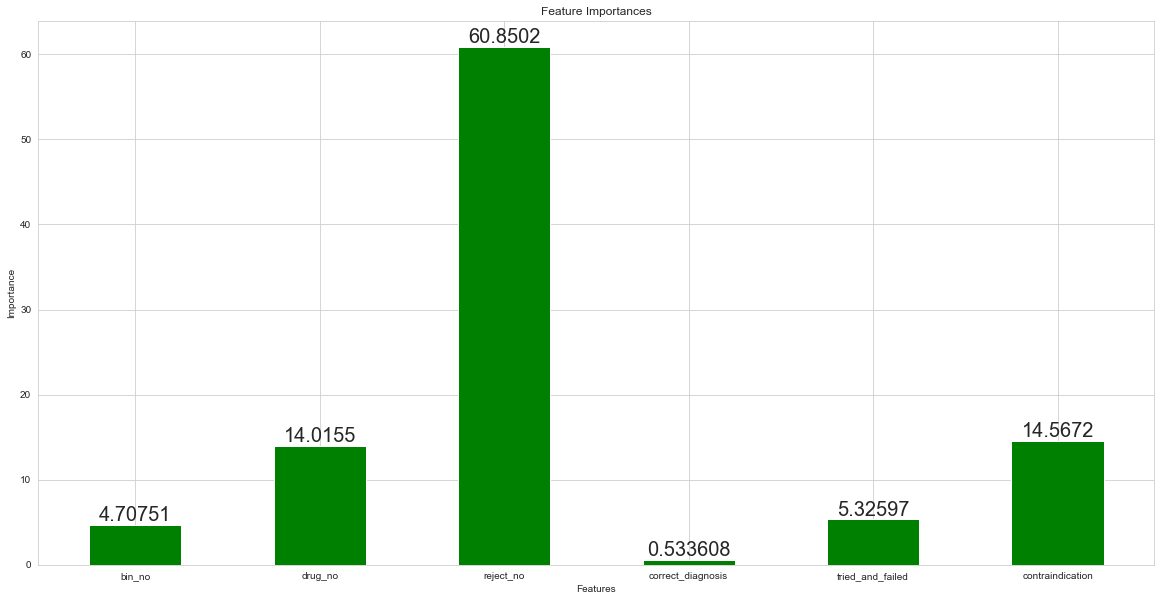

In [14]:
# Bar plot for the feature importances.


fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)

ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

In [13]:
model.feature_importances_

array([ 4.70750871, 14.01550504, 60.85016738,  0.53360848,  5.32596687,
       14.56724353])

We see correct_diagnasis has the least importance, so we will try a model without it:

0:	learn: 0.4205022	total: 48ms	remaining: 432ms
1:	learn: 0.3849603	total: 95.4ms	remaining: 381ms
2:	learn: 0.3775526	total: 138ms	remaining: 321ms
3:	learn: 0.3764987	total: 187ms	remaining: 281ms
4:	learn: 0.3742753	total: 243ms	remaining: 243ms
5:	learn: 0.3735111	total: 292ms	remaining: 194ms
6:	learn: 0.3730695	total: 339ms	remaining: 145ms
7:	learn: 0.3726214	total: 389ms	remaining: 97.3ms
8:	learn: 0.3724399	total: 434ms	remaining: 48.2ms
9:	learn: 0.3724133	total: 476ms	remaining: 0us
Validation Results:
Accuracy: 81.40%
Precision: 84.42%
Recall: 91.58%
f1: 87.85%
Train Results:
Accuracy: 81.40%
Precision: 84.42%
Recall: 91.58%
f1: 87.85%


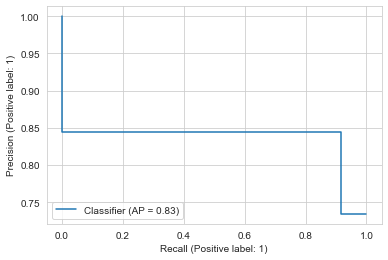

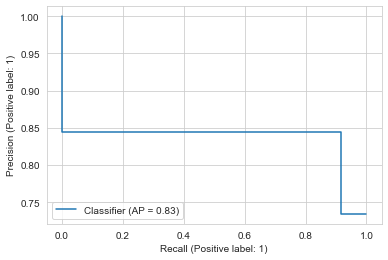

In [57]:
features = ['bin_no','drug_no', 'reject_no', 'tried_and_failed', 'contraindication']

model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=4)

model.fit(pa_tt[features].values, pa_tt['pa_approved'])

# make predictions for validation data
y_pred = model.predict(pa_val[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for validation data
accuracy = accuracy_score(pa_val['pa_approved'], predictions)
precision = precision_score(pa_val['pa_approved'], predictions)
recall = recall_score(pa_val['pa_approved'], predictions)
f1 = f1_score(pa_val['pa_approved'], predictions)
print("Validation Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_val['pa_approved'], predictions)

# make predictions for training data
y_pred = model.predict(pa_tt[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for training data
accuracy = accuracy_score(pa_tt['pa_approved'], predictions)
precision = precision_score(pa_tt['pa_approved'], predictions)
recall = recall_score(pa_tt['pa_approved'], predictions)
f1 = f1_score(pa_tt['pa_approved'], predictions)
print("Train Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_tt['pa_approved'], predictions)


This is a simpler model with almost the same performance.

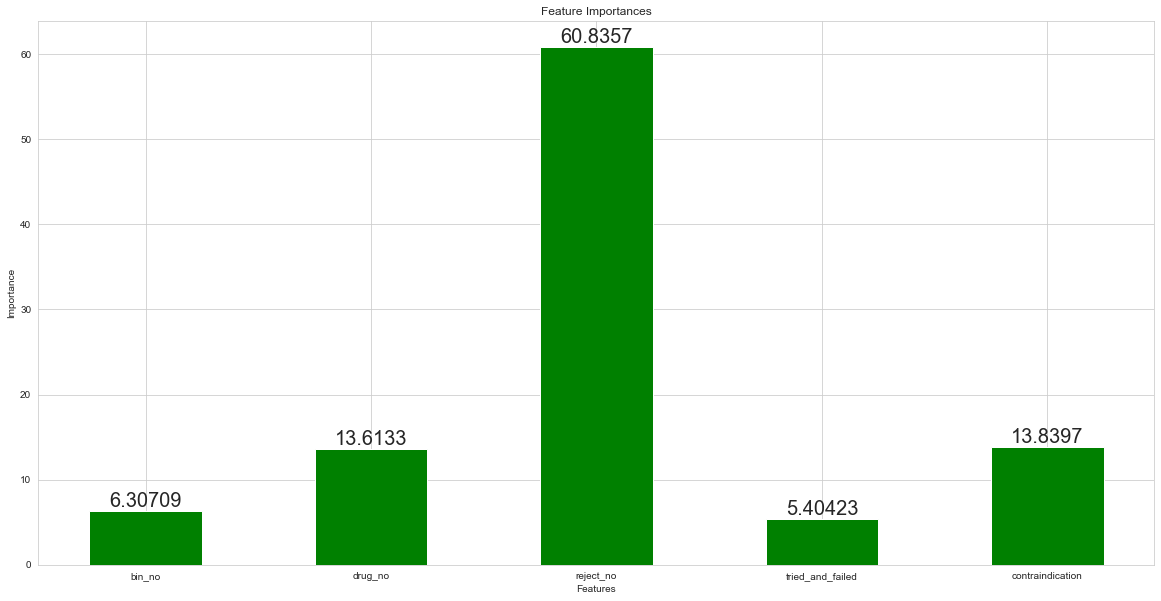

In [59]:
# Bar plot for the feature importances.


fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)

ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

In [6]:
len([0,1,2])

3

In [10]:
np.zeros((3, 4))[1,2]

0.0